In my classification-related jupyter notebook, I describe how I want to solve this problem by taking two different approaches. Previously I tackled this problem through the Classification approach after creating an augmented dataset by offline data augmentation method. In addition, I use my custom build network RAM-Net to tackle this issue. Moreover, the approach was successful as my network was able to classify the 7 real images (which are given by extend ai) correctly.

# Segmentation Process

Here, I try to solve this issue through segmentation. For the segmentation, I use the offline data augmentation method to create a paired augmented dataset (base image, mask). Next, I use the popular deep learning model U-Net to predict the segmentation mask.

# Data Preparation

For data preparation, I used offline data augmentation to create the paired train and validation set. 

At first, I took 7 real images which were provided by Extend AI, and I utilized CVAT (https://cvat.org/) computer vision annotation tools to create ground truth segmentation masks. 

Secondly, I used offline data augmentation to create paired (base image and segmentation mask) image train set and validation set. For the training, I provide a total of 350 paired images (7*50 means 50 images from each real image). For the validation, I created 56 paired images (7*8 means 8 images from each real image). 

Thirdly, for the testing, I used 7 real images and corresponding ground truth segmentation masks to perform the qualitative evaluation. 

Lastly, I perform normalization and convert the images to gray level to cut the computation and make a proficient training procedure.




# Architecture

I use popular U-Net architecture to tackle this task. As Input, I use the NumPy array and resize the dimension to (224 X 224 X 1). For the loss function, I used binary cross-entropy loss. I used several call-back functionalities such as ReduceLROnPlateau, EarlyStopping, and ModelCheckpoint. Furthermore, I used Adam optimizer as the optimization function, and the batch size is 8. 



In [228]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
#print(tf.__version__)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Take all the data is in a NumPy format.

In [229]:
#Train set
images=np.load('D:/aminur/anomaly dataset/npy_real.npy')
mask=np.load('D:/aminur/anomaly dataset/npy_mask.npy')

#validation set
images_val=np.load('D:/aminur/anomaly dataset/npy_val_real.npy')
mask_val=np.load('D:/aminur/anomaly dataset/npy_val_mask.npy')

print(mask.max(), mask.min(),images.max(),images.min())
print(images.shape,mask.shape)

1.0 0.0 0.95686275 0.0
(350, 224, 224) (350, 224, 224)


Example of one image and corresponding segmentation map from the augmented dataset. I think the gray level would be enough to tackle this problem and find a good prediction.

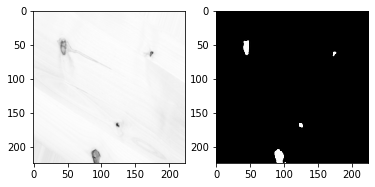

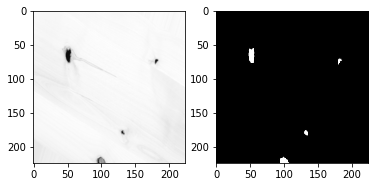

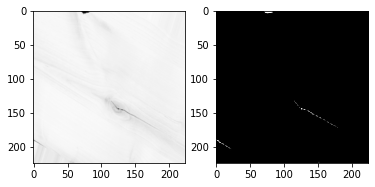

In [230]:
#display three examples
def display(x,y):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    # Bilinear interpolation - this will look blurry
    ax1.imshow(x, interpolation='bilinear', cmap=cm.Greys_r)

    ax2 = fig.add_subplot(122)
    # 'nearest' interpolation - faithful but blocky
    ax2.imshow(y, interpolation='nearest', cmap=cm.Greys_r)

    plt.show()
display(images[100],mask[100])
display(images[200],mask[200])
display(images[250],mask[250])

I think the dimension of the image 224X224 would be enough for this task to predict some good results. At the same time, it will minimize the Flops of the network.

In [231]:
dim=224
images = np.array(images).reshape(len(images),dim,dim,1)
mask = np.array(mask).reshape(len(mask),dim,dim,1)
images_val=np.array(images_val).reshape(len(images_val),dim,dim,1)
mask_val=np.array(mask_val).reshape(len(mask_val),dim,dim,1)

In [232]:
#Unet Network
def unet(input_size=(224,224,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [233]:
model = unet(input_size=(224,224,1))
#lr=1e-5
#model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
#                  metrics=[dice_coef, 'binary_accuracy'])

model.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_381 (Conv2D)             (None, 224, 224, 32) 320         input_21[0][0]                   
__________________________________________________________________________________________________
conv2d_382 (Conv2D)             (None, 224, 224, 32) 9248        conv2d_381[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_81 (MaxPooling2D) (None, 112, 112, 32) 0           conv2d_382[0][0]                 
___________________________________________________________________________________________

Callback function: We need it to inspect the training procedure and based on the result, we can decide about our hyperparameters.  

In [234]:
weight_path="D:/aminur/anomaly dataset/{}_weights.best.hdf5".format('anomaly_reg')

#callback Functions
checkpoint = ModelCheckpoint('D:/aminur/anomaly dataset/model_Unet_anomly.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=15, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint,early, reduceLROnPlat]

D:\Anaconda3\envs\deep\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Run this model for 100 epoch with batch size 8. 

In [262]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
#lr=2e-4
'''model.compile(optimizer=Adam(lr=1e-5), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef,'binary_accuracy'])'''
model.compile(Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])


#train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
 #                                                           test_size = 0.1, 
  #                                                          random_state = 2018)
#print(images.shape)
loss_history = model.fit(x = images,
                       y = mask,
                         batch_size = 8,
                  epochs = 100,
                  validation_data =(images_val,mask_val) ,
                  callbacks=callbacks_list)


#clear_output()

Train on 350 samples, validate on 56 samples
Epoch 1/100
350/350 [==============================] - 6s 17ms/step - loss: 0.0017 - accuracy: 0.9954 - val_loss: 0.0012 - val_accuracy: 0.9958

Epoch 00001: val_loss did not improve from 0.00106
Epoch 2/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0012 - accuracy: 0.9955 - val_loss: 0.0011 - val_accuracy: 0.9958

Epoch 00002: val_loss did not improve from 0.00106
Epoch 3/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0012 - accuracy: 0.9955 - val_loss: 0.0011 - val_accuracy: 0.9958

Epoch 00003: val_loss did not improve from 0.00106
Epoch 4/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0012 - accuracy: 0.9955 - val_loss: 0.0011 - val_accuracy: 0.9958

Epoch 00004: val_loss did not improve from 0.00106
Epoch 5/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0012 - accuracy: 0.9955 - val_loss: 0.0011 - val_accuracy: 0.9958

Epoch 00005: val_loss did 

Epoch 40/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0011 - accuracy: 0.9955 - val_loss: 0.0010 - val_accuracy: 0.9958

Epoch 00040: val_loss improved from 0.00105 to 0.00104, saving model to D:/aminur/anomaly dataset/model_Unet_anomly.h5
Epoch 41/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0011 - accuracy: 0.9955 - val_loss: 0.0010 - val_accuracy: 0.9958

Epoch 00041: val_loss improved from 0.00104 to 0.00104, saving model to D:/aminur/anomaly dataset/model_Unet_anomly.h5
Epoch 42/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0011 - accuracy: 0.9955 - val_loss: 0.0010 - val_accuracy: 0.9958

Epoch 00042: val_loss improved from 0.00104 to 0.00104, saving model to D:/aminur/anomaly dataset/model_Unet_anomly.h5
Epoch 43/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0011 - accuracy: 0.9955 - val_loss: 0.0010 - val_accuracy: 0.9958

Epoch 00043: val_loss improved from 0.00104 to 0.00104, sav

Epoch 72/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0011 - accuracy: 0.9955 - val_loss: 0.0010 - val_accuracy: 0.9958

Epoch 00072: val_loss improved from 0.00103 to 0.00103, saving model to D:/aminur/anomaly dataset/model_Unet_anomly.h5
Epoch 73/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0011 - accuracy: 0.9955 - val_loss: 0.0010 - val_accuracy: 0.9958

Epoch 00073: val_loss did not improve from 0.00103
Epoch 74/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0011 - accuracy: 0.9955 - val_loss: 0.0010 - val_accuracy: 0.9958

Epoch 00074: val_loss improved from 0.00103 to 0.00103, saving model to D:/aminur/anomaly dataset/model_Unet_anomly.h5
Epoch 75/100
350/350 [==============================] - 5s 15ms/step - loss: 0.0011 - accuracy: 0.9955 - val_loss: 0.0010 - val_accuracy: 0.9958

Epoch 00075: val_loss improved from 0.00103 to 0.00103, saving model to D:/aminur/anomaly dataset/model_Unet_anomly.h5
Epoch 76

Inspect the training vs validation loss and training accuracy vs validation accuracy of our network. 

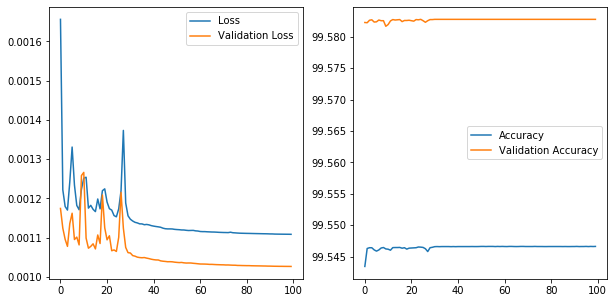

In [272]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()
#ax2.set_ylim([80,100])
plt.show()

Inspect the Qualitative analysis of our test set (7 real images from Extend AI). We check all 7 images and display the real RGB images with ground truth segmentation map and predicted segmentation map. 

In the following section: 
1. real= real RGB image
2. mask= ground truth segmentation mask
3. predicted= predicted segmentation mask



7/7 [==============================] - 0s 17ms/step
<class 'numpy.ndarray'> (7, 224, 224)


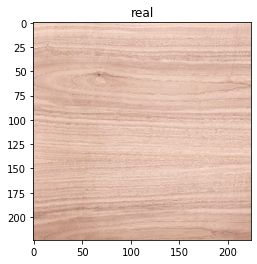

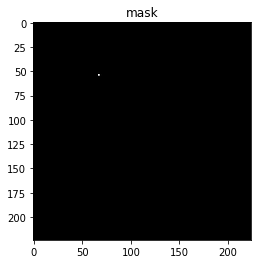

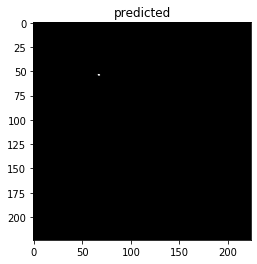

In [264]:
images_test=np.load('D:/aminur/anomaly dataset/npy_test_real.npy')
mask_test=np.load('D:/aminur/anomaly dataset/npy_test_mask.npy')

images_test_re=np.array(images_test).reshape(len(images_test),dim,dim,1)

test_real=np.load('D:/aminur/anomaly dataset/npy_test_RGB_real.npy')


preds = model.predict(images_test_re,batch_size=1,verbose=1)

preds=np.array(preds).reshape(len(preds),dim,dim)
print(type(preds),preds.shape)
def display(x,name):
    fig = plt.figure()
    ax1 = fig.add_subplot()
    # Bilinear interpolation - this will look blurry
    ax1.imshow(x,cmap=cm.Greys_r)

    #ax2 = fig.add_subplot(322)
    # 'nearest' interpolation - faithful but blocky
    #ax2.imshow(y,cmap=cm.Greys_r)
    
    #ax3 = fig.add_subplot(323)
    # 'nearest' interpolation - faithful but blocky
    #ax3.imshow(z,cmap=cm.Greys_r)
    ax1.title.set_text(name)
    #ax2.title.set_text('Second Plot')
    #ax3.title.set_text('Third Plot')

    plt.show()

display(test_real[0],name='real')
display(mask_test[0],name='mask')
display(preds[0],name='predicted')
#display(images[200],mask[200])
#display(images[250],mask[250])


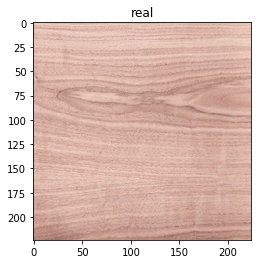

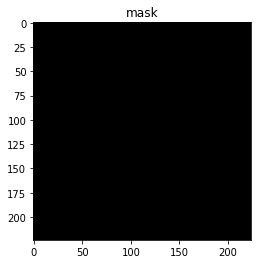

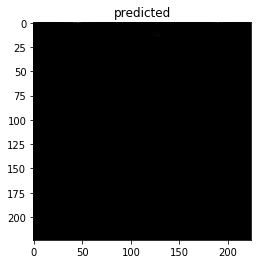

In [265]:
display(test_real[1],name='real')
display(mask_test[1],name='mask')
display(preds[1],name='predicted')

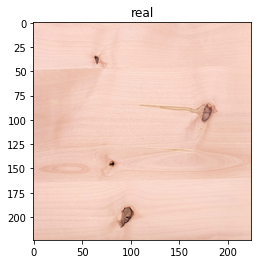

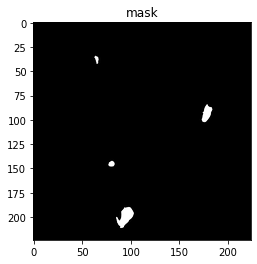

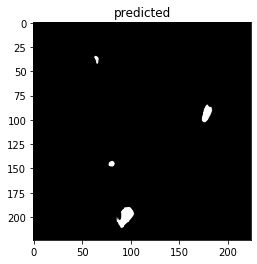

In [266]:
display(test_real[2],name='real')
display(mask_test[2],name='mask')
display(preds[2],name='predicted')

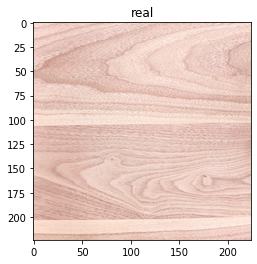

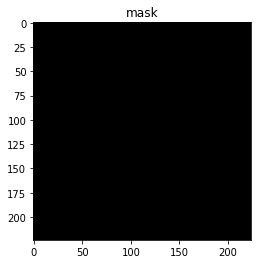

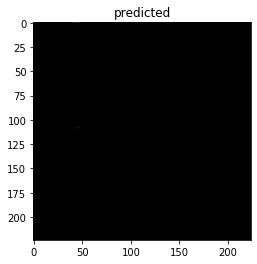

In [267]:
display(test_real[3],name='real')
display(mask_test[3],name='mask')
display(preds[3],name='predicted')

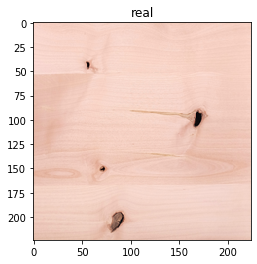

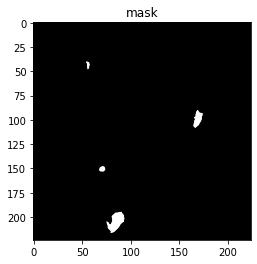

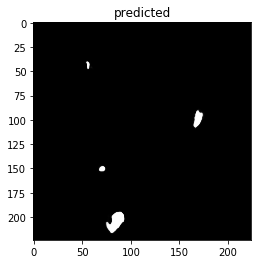

In [268]:
display(test_real[4],name='real')
display(mask_test[4],name='mask')
display(preds[4],name='predicted')

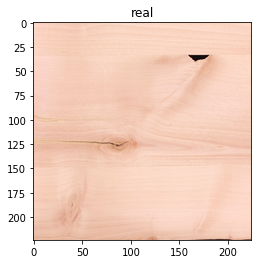

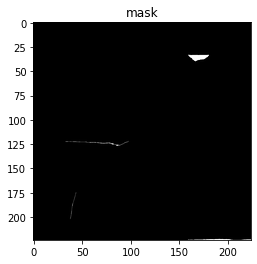

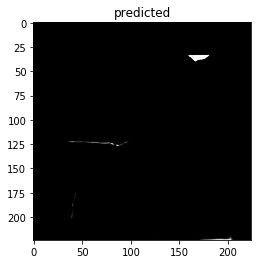

In [269]:
display(test_real[5],name='real')
display(mask_test[5],name='mask')
display(preds[5],name='predicted')

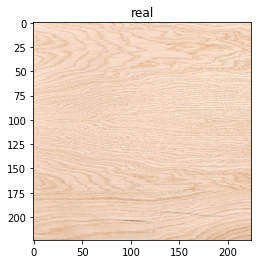

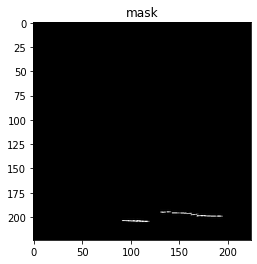

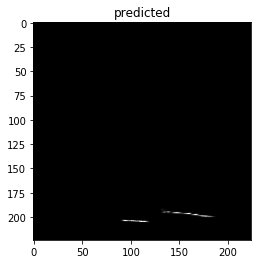

In [270]:
display(test_real[6],name='real')
display(mask_test[6],name='mask')
display(preds[6],name='predicted')

To sum up, I can easily say that the segmentation result is pretty good, and I think my approach to performing this task is successful. However, there is always some room for improvement in this kind of issue.

# how you would improve the model in the near future? 

I can take several steps to improve this method:
1. At first, we can have more realistic images to make our dataset because right now, the model is trained and validated on augmented images. 
2. I can try some other network or my custom build network, which performs better than U-Net. Some networks such as HR-Net or HR-Net lookalike custom-made networks would be perfect for this task.
3. Most importantly, I want to build a model where the network can perform segmentation, classification, and detection combinedly (something like Mask-R-CNN).
4. I performed the online augmentation during the training process in my classification network. Moreover, I want to perform the same procedure in my segmentation network as well. 
5. For both classification and segmentation, I want to apply online data augmentation for the validation set as well
6. During the classification, I used the pre-trained weight of Imagenet in the backbone, but I did not take any pre-trained weight in the segmentation task. I think this pre-trained weight can enhance the segmentation result.


# how you would transfer learnings to other types of surfaces (i.e. not wood)?

Transfer Learning is a popular deep learning and machine learning method where we train our model on a particular task, and then we can apply that knowledge to a related second task. Through this approach, we can enhance the performance and prediction when modeling the second task. By this approach, we can improve the result where we have a small dataset to train with.  

For example, here, we can shift the weight of the anomaly detection task of wood into a related second task. If we train our anomaly detection architecture with a large dataset, then we can easily transfer this knowledge. Generally, in computer vision, we detect the edges of images in the first few layers, in the middle layers mostly detect forms, and the last few layers detect the task-specific features such as anomaly for this task. So for the second task, we only have to retrain the last few layers, but the earlier layers and the middle layers are employed in transfer learning.


